### MSP Projekt 2
## Autor: Vojtěch Fiala \<xfiala61\>


Než začne implementace čehokoliv, je nutné nejprve importovat potřebné knihovny

In [1]:
import matplotlib as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv

# 1. úkol

## 1.a) Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

## 1.a.1) Apriorní a aposteriorní hustota parametru Poissonova rozdělení 𝜆.

Určím si parametry gamma rozdělení alfa a beta na základě toho, že alfa je počet událostí za beta intervalů.
Tomu odpovídá 

$\Gamma(10,5)$

Moje apriorní pravděpodobnsot je toto rozdělení. 

Posteriorní pravděpodobnosti určím podle poskytnutého vzorce na wiki:

$\Gamma(10 + \sum{x_i}, 5 + n)$

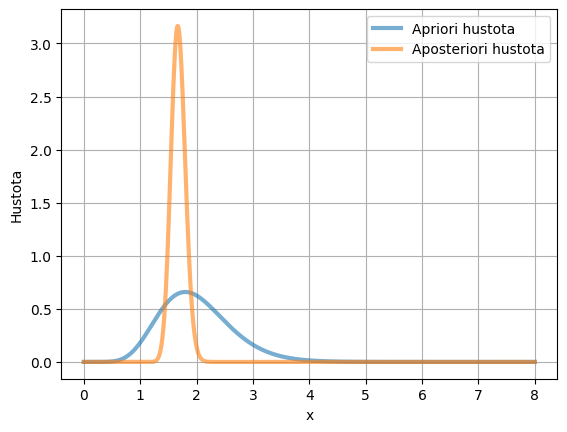

In [2]:
DATA_FILE = "Projekt-2_ukol1.csv"
values = pd.read_csv(DATA_FILE)

observations = values[~values['uloha_1a'].isna()]["uloha_1a"].astype(int)

alpha = 10 # 10 udalosti 
beta = 5 # v 5 intervalech

x = np.linspace(0, 8, 1000)
conjugated_gamma_prior = stats.gamma(a=alpha, scale=1/beta)

alpha_post = alpha + np.sum(observations) # podle wiki 
beta_post = beta + len(observations)

conjugated_gamma_posterior = stats.gamma(a=alpha_post, scale=1/beta_post)

fig, ax = plt.subplots(1, 1)
ax.plot(x, conjugated_gamma_prior.pdf(x), lw=3, alpha=0.6, label='Apriori hustota')
ax.plot(x, conjugated_gamma_posterior.pdf(x), lw=3, alpha=0.6, label='Aposteriori hustota')
plt.xlabel('x')
plt.grid(True)
plt.ylabel('Hustota')
plt.legend()
plt.show()


## 1.a.2) Apriorní a aposteriorní prediktivní hustota pozorovaní 𝑥 za jeden časový interval

Pro aposteriori prediktivní hustotu vyjdu opět ze vzorce na wiki (negativní binomické rozdělení):


$NB(\alpha + \sum{x_i}, \frac{\beta + n}{1 + \beta + n})$

Pro apriori aplikuju totéž rozdělení, ale dám mu původní alfa a beta hodnoty, tedy:

$NB(\alpha, \frac{\beta}{1 + \beta})$

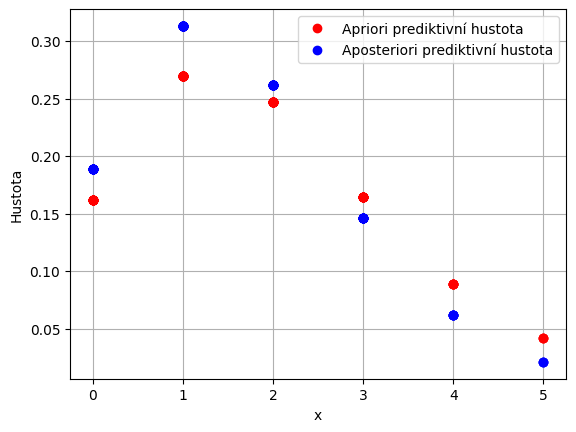

In [3]:
# Apriori NB rozdeleni
apriori_nb = stats.nbinom(alpha, beta/(1+beta))

# Aposteriori NB
aposteriori_nb = stats.nbinom(alpha_post, beta_post/(1+beta_post))

fig, ax = plt.subplots(1, 1)
ax.plot(observations, apriori_nb.pmf(observations), 'o', label='Apriori prediktivní hustota', color='r')
ax.plot(observations, aposteriori_nb.pmf(observations), 'o', label='Aposteriori prediktivní hustota', color='b')

plt.xlabel('x')
plt.grid(True)
plt.ylabel('Hustota')
plt.legend()
plt.show()


## 1.a.3) Sestrojte 95% interval spolehlivosti pro parametr 𝜆 z apriorního a aposteriorního rozdělení a porovnejte je

Pro sestrojení intervalů spolehlivosti využiju metody .interval již vygenerovaného rozdělení.

Intervaly si zobrazím v jednoduchém grafu

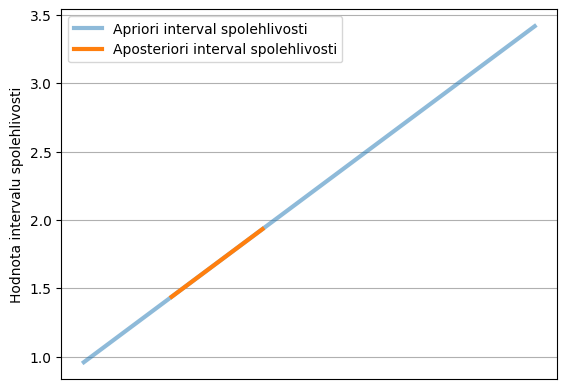

In [4]:

lambda_aprior = conjugated_gamma_prior.interval(0.95)
lambda_aposterior = conjugated_gamma_posterior.interval(0.95)


fig, ax = plt.subplots(1, 1)
plt.plot(lambda_aprior, lambda_aprior,  lw=3, alpha=0.5, label='Apriori interval spolehlivosti')
plt.plot(lambda_aposterior, lambda_aposterior, lw=3, label='Aposteriori interval spolehlivosti')
plt.grid(True)
plt.legend()
ax.axes.get_xaxis().set_ticks([])
plt.ylabel('Hodnota intervalu spolehlivosti')

plt.grid(True)
plt.show()

Je patrné, že interval spolehlivosti vycházející z apriorního rozdělení je daleko širší než interval z aposteriorního rozdělení, což odpovídá tomu, že aposteriori informace je přesnější.

## 1.a.4) Vyberte si dva aposteriorní bodové odhady parametru 𝜆, porovnejte je a okomentujte jejich výběr

Zvolím si bodový odhad střední hodnoty (mean) a směrodatné odchylky (variance). Budu vycházet z aposteriorní gamma hustoty.

Pro gamma rozdělení platí, že střední hodnota je $\frac{\alpha}{\beta}$ a směrodatná odchylka $\frac{\alpha}{\beta^2}$

In [5]:
mean = alpha_post/beta_post
print(mean)

variance = alpha_post/(beta_post*beta_post)
print(variance)

1.6761904761904762
0.01596371882086168


Bodový odhad střední hodnoty koresponduje s tím, co lze podle grafu z úlohy 1.a.1) očekávat.

Odpovídá tomu i směrodatná odchylka, která je velmi nízká, což odpovídá i grafu, kde jsou hodnoty taktéž velmi blízko u sebe.

## 1.a.5) Vyberte si jeden apriorní a jeden aposteriorní bodový odhad počtu pozorovaní a porovnejte je. 

Zvolím si apriorní střední hodnotu a aposteriorní střední hodnotu počtu pozorování. Budu vycházet z negativního binomického rozdělení.

Vzorec pro střední hodnotu pro negativní binomické rozdělení je $E(x) = \frac{r \times (1-p)}{p}$

In [6]:
r = alpha
p = beta/(1+beta)

apriori_mean = (r * (1-p))/p

r_post = alpha_post
p_post = beta_post/(1+beta_post)

aposteriori_mean = (r_post * (1-p_post))/p_post

print(apriori_mean, aposteriori_mean)

1.9999999999999996 1.6761904761904758


Apriorní střední hodnota je vyšší než posteriorní. To opět odpovídá grafu z úlohy 1.a.2, kde je vidět, že apriori prediktivní hustota je z počátku nižší a pro vyšší x je vyšší.

Oproti tomu aposteriorní střední hodnota je vyšší na začátku a nižší později, takže obě hodnoty odpovídají grafu.

# 2. úkol

## 2.1) Výpočet regresního modelu

Začnu importem knihovny pro počítání regrese a načtením samotných dat ze souboru, kterými naplním dataframe

In [7]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.api.types import is_string_dtype

DATA_FILE = "Projekt-2_ukol2.csv" # Z excelu jsem importoval data do csv pro lepsi cteni
df = pd.read_csv(DATA_FILE)

# Prejmenuju Ping [ms] na Ping
df.rename(columns = {'Ping [ms]':'Ping'}, inplace = True) 

Konverze hodnot, které jsou v podobě stringu na čísla a řešení kategorického atributu (OSType) a řešení závislosti sloupců.

OSType za pomoci techniky one-hot encoding převedu na nové sloupce pro každý operační systém, kdy 1 implikuje, že sloupec má daný OS a 0 že ne.
Aby byl model úspornější, jednu z nich vyhodím (jelikož např. na enkódování 2 hodnot mi stačí 1 sloupec - True/False) a tím pádem pokud jsou všechny sloupce 0, reprezentují mi chybějící hodnotu (android) implicitně.

In [8]:
# Konverze desetinnych carek na tecky kterym Python rozumi
if (is_string_dtype(df["InteractingPct"])):
    df["InteractingPct"] = df["InteractingPct"].str.replace(",", ".")
    try:
        df["ScrollingPct"] = df["ScrollingPct"].str.replace(",", ".")
        
        # Na prvni pohled je patrne, ze InteractingPct a ScrollingPct jsou na sobe zavisle vztahem kde
        # InteractingPct = 1 - ScrollingPct a ScrollingPCt = 1 - InteractingPct
        # To overim vypoctu koeficientu korelace
        print("Korelacni koeficienty sloupcu:")
        print(df[["InteractingPct", "ScrollingPct"]].corr())
        
        
        # Koeficient korelace vychazi -1 pro oba sloupce - jsou na sobe naprosto ve vsem zavisle
        # Takze proste jeden z nich vyhodim (ScrollingPct), protoze ho umim kdykoliv dopocitat
        df = df.drop("ScrollingPct", axis=1)
    except:
        pass

# Konverze jednotlivych sloupcu do spravnych datovych typu
df[["ActiveUsers", "Ping", "InteractingPct"]] = df[["ActiveUsers", "Ping", "InteractingPct"]].apply(pd.to_numeric)

try:
    # OSType je kategoricky, je potreba ho prevest na neco zpracovatelnejsiho - one hot encoding, drop first mi udela model uspornejsi
    one_hot = pd.get_dummies(df['OSType'], drop_first=True).astype(int)
    
    # Smazu puvodni hodnoty
    df = df.drop('OSType', axis=1)
    
    # Pridanim encodovane hodnoty
    df = df.join(one_hot)
except:
    pass

Korelacni koeficienty sloupcu:
                InteractingPct  ScrollingPct
InteractingPct             1.0          -1.0
ScrollingPct              -1.0           1.0



Definuju si výchozí regresní model - plný kvadratický model.
Hodnota, kterou se budu snažit vyjádřit, bude Ping (kvůli pozdější úloze).



Takže plný kvadratický model bude:

$Ping = \beta_0 + \beta_1 \times (ActiveUsers) + \beta_2 \times (InteractingPct) + \beta_3 \times (MacOS) + \beta_4 \times (Windows) + \beta_5 \times (iOS) 
$

$
+ \beta_6 \times (ActiveUsers \cdot ActiveUsers) + \beta_7  \times (ActiveUsers \cdot InteractingPct) + \beta_8 \times (ActiveUsers \cdot MacOS) 
$

$
+ \beta_9 \times (ActiveUsers \cdot Windows) + \beta_{10} \times (ActiveUsers \cdot iOS) + \beta_{11} \times (InteractingPct \cdot InteractingPct) 
$

$
+ \beta_{12} \times (InteractingPct \cdot MacOS) + \beta_{13} \times (InteractingPct \cdot Windows) + \beta_{14} \times (InteractingPct \cdot iOS)
$

Ještě než se pustím do zpětne eliminace, vyřeším multikolinearitu.

K tomu použiju Z-score a VIF pro určení, kde k ní dochází.

In [9]:
# Puvodni formule je plneho kvadratickeho modelu
formula = "Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS + I(ActiveUsers**2) + ActiveUsers:InteractingPct\
+ ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS + I(InteractingPct**2) + \
InteractingPct:MacOS + InteractingPct:Windows + InteractingPct:iOS"

# Kratka funkce na ziskani vysledneho modelu
def getResults(df, formula, p=True):
    # Standardni least squares model
    model=smf.ols(formula=formula, data=df)
    results=model.fit()
    if p:
        print(results.summary())
    return results, model

results, model = getResults(df, formula, p=False)

# Prevzato z democvika
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()
vif_df.columns = ['VIF']
print('\n\n\n')
print(vif_df)

df2 = df.copy()
df2_activeUsers_original_mean = df2['ActiveUsers'].mean()
df2_activeUsers_original_std = df2['ActiveUsers'].std()
df2_InteractingPct_original_std = df2['InteractingPct'].std()
df2_InteractingPct_original_mean = df2['InteractingPct'].mean()

# Krom konstanty je zjevne problem v ActiveUsers a InteractingPct - kvuli jejich druhym mocninam - prevedu to na Z-score
df2['ActiveUsers']=(df2['ActiveUsers']-df2_activeUsers_original_mean)/df2_activeUsers_original_std
df2['InteractingPct']=(df2['InteractingPct']-df2_InteractingPct_original_mean)/df2_InteractingPct_original_std

results, model = getResults(df2, formula, p=False)
# Znovu si spocitam VIF
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
vif_df = vif.to_frame()
vif_df.columns = ['VIF']
print('\n\n\n')
print(vif_df)
print('\n\n\n')

# Zadny VIF uz neni >10, coz povazuju (podle democvika) za dostacujici






                                  VIF
Intercept                   79.081437
ActiveUsers                 30.108570
InteractingPct              26.021105
MacOS                       14.530955
Windows                     13.726080
iOS                         13.164975
I(ActiveUsers ** 2)         22.499134
ActiveUsers:InteractingPct   8.851002
ActiveUsers:MacOS           10.454073
ActiveUsers:Windows         10.189613
ActiveUsers:iOS              9.061267
I(InteractingPct ** 2)      16.060875
InteractingPct:MacOS         7.586537
InteractingPct:Windows       6.857633
InteractingPct:iOS           6.028016




                                 VIF
Intercept                   6.781856
ActiveUsers                 4.918200
InteractingPct              4.737489
MacOS                       1.654677
Windows                     1.630480
iOS                         1.606613
I(ActiveUsers ** 2)         1.019635
ActiveUsers:InteractingPct  1.041103
ActiveUsers:MacOS           2.335540
ActiveUsers:Wi

Zjistil jsem, že problematické hodnoty jsou ActiveUsers a InteractingPct.

Tahle normalizace znamená, že sloupce ActiveUsers a InteractingPct budou **normalizované** a tedy **je nutné s tím počítat, pokud bych model krmil novými daty -- je nutné ty data taky normalizovat**! Jinak by vycházely nesmysly.

Teď se můžu pustit do samotné zpětné eliminace.

Jdu tak dlouho, dokud žádná hodnota nepřekračuje hranici významnosti **5%**.
Vypisuju jen první a poslední model, zakomentované řádky sloužily k výpisu změn a určení, které hodnoty odstranit při zpětné eliminaci. Taky obsahují P-hodnoty jednotlivých prvků modelu, které jsem podle ní odstranil.

In [10]:
# Ted se muzu pustit do pocitani optimalniho modelu - Zacnu zpetnou eliminaci:
results, model = getResults(df2, formula)


"""#Zakomentovany kod obsahuje jednotlive kroky zpetne eliminace vcetne P-hodnot, podle kterych jsem odstranoval

# P-hodnota InteractingPct:iOS je nejvyssi 0.921, smazu ho a jedu znovu dokud zadna P-hodnota neprekroci hranici vyznamnosti 0.05
# Musim ho smazat z formule

formula = "Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS + I(ActiveUsers**2) + ActiveUsers:InteractingPct\
+ ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS + I(InteractingPct**2) + \
InteractingPct:MacOS + InteractingPct:Windows"
results, model = getResults(df2, formula)

# Dalsi je InteractingPct:Windows s 0.902

formula = "Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS + I(ActiveUsers**2) + ActiveUsers:InteractingPct\
+ ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS + I(InteractingPct**2) + \
InteractingPct:MacOS"

results, model = getResults(df2, formula)

# INteractingPct:MacOS 0.76

formula = "Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS + I(ActiveUsers**2) + ActiveUsers:InteractingPct\
+ ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS + I(InteractingPct**2)"

results, model = getResults(df2, formula)
"""
# InteractPct^2 0.278

formula = "Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS + I(ActiveUsers**2) + ActiveUsers:InteractingPct\
+ ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS"

results, model = getResults(df2, formula)

# Hotovo, uz nic (krom konstanty) nema vic nez 0
# Vysledny model je tedy Ping ~ ActiveUsers + InteractingPct + Windows + I(ActiveUsers**2) + ActiveUsers:InteractingPct

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        03:13:39   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Mám sice hotový model, ale měl bych z něj odstranit případné **extrémní hodnoty**.
Budu je řešit výpočtem Cookovy vzdálenosti a podle ní případné extrémy smažu.


Graf s extremy


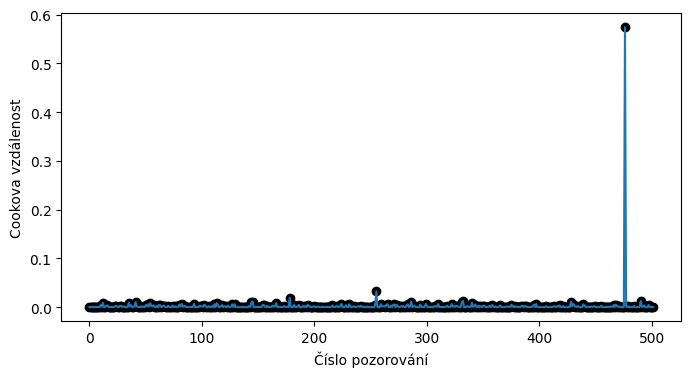

Problemove hodnoty:
      ActiveUsers  InteractingPct  Ping  MacOS  Windows  iOS
178         1207          0.0766    33      0        1    0
255         5513          0.4912    90      0        1    0
476          153          0.2111    61      1        0    0
                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     353.7
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          2.30e-216
Time:                        03:13:39   Log-Likelihood:                -1522.6
No. Observations:                 499   AIC:                             3067.
Df Residuals:                     488   BIC:                             3114.
Df Model:                          10                                         
Covariance Type:            

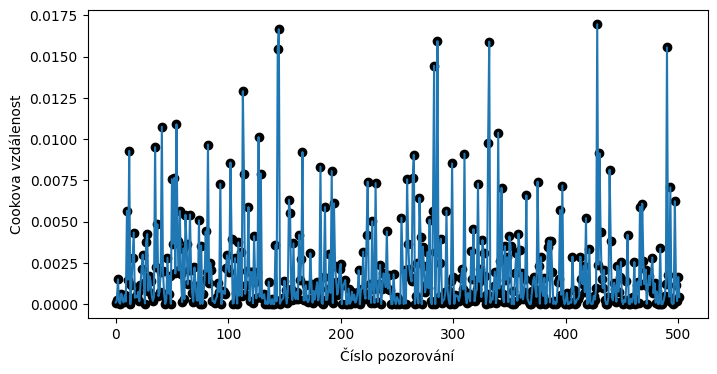


Parametry modelu:
Intercept                     51.351814
ActiveUsers                   10.050555
InteractingPct                 5.171482
MacOS                          8.998724
Windows                        3.571328
iOS                           -5.714999
I(ActiveUsers ** 2)           -3.067622
ActiveUsers:InteractingPct    -2.620188
ActiveUsers:MacOS              4.441268
ActiveUsers:Windows           -1.751166
ActiveUsers:iOS               -2.765897
dtype: float64


In [11]:
# Projdu pres Cook's distance hodnoty, ze nejsou extremni a pripadne je smazu a model spocitam znova
influence = results.get_influence()

# Cookovy vzdalenosti
cooks = influence.cooks_distance

print("Graf s extremy")
plt.figure(figsize = (8, 4))
plt.scatter(df2.index, cooks[0], color='black')
plt.plot(df2.index, cooks[0])
plt.xlabel('Číslo pozorování')
plt.ylabel('Cookova vzdálenost')
plt.show()

# Jak vyplyva z grafu, par extremu je skutecne pritomno - pokud
# Vypocitam prumernou cookovu vzdalenost a pokud jsou nektere hodnoty vic nez 5x odlisnejsi, zbavim se jich

cook_avg_multiplied = np.average(cooks[0]) * 5

indexes = df2.index[cooks[0] < cook_avg_multiplied] # Indexy ktere splnuji muj pozadavek
problem_index = df2.index[cooks[0] > cook_avg_multiplied]

# Problemove hodnoty se zdaji byt realne, ovsem jsou jen 3 a bez nich je model lepsi
print("Problemove hodnoty:\n", df.iloc[problem_index, :])

df3 = df2.iloc[indexes, :]
      
# Znovu spocitam model
results_final, model_final = getResults(df3, formula)

# Graf bez extremu
influence = results_final.get_influence()
cooks = influence.cooks_distance

print("Graf bez extremu:")
plt.figure(figsize = (8, 4))
plt.scatter(df3.index, cooks[0], color='black')
plt.plot(df3.index, cooks[0])
plt.xlabel('Číslo pozorování')
plt.ylabel('Cookova vzdálenost')
plt.show()

print("\nParametry modelu:")
print(results_final.params)

Smazal jsem 3 problémové hodnoty, které se ale výrazně nelišily od ostatních -- jsou tedy nejspíš validní, ovšem bez nich je model lepší (vyšší R-squared). Aby je bylo vhodné použít, bylo by vhodné mít k dispozici ještě větší vzorek dat, ve kterém by podobných hodnot bylo víc.


Jakmile žádný prvek modelu nepřekračuje p-hodnotou 0.05 a zároveň je vyřešena multikolinearita a extrémní hodnoty, považuju model za __hotový__.

## Výsledek 2.1.1) Formule modelu

Formule modelu je:

$
Ping = 51.394821 + 10.050555 \times ActiveUsers + 5.171482 \times InteractingPct +  8.998724 \times MacOS + 3.571328 \times Windows - (-5.714999) \times iOS 
$

$
+ (-3.067622) \times ActiveUsers^2 + (-2.620188) \times (ActiveUsers \cdot InteractingPct) +  4.441268 \times (ActiveUsers \cdot MacOS)
$

$
+ (-1.751166) \times (ActiveUsers \cdot Windows) + (-2.765897) \times (ActiveUsers \cdot iOS)
$



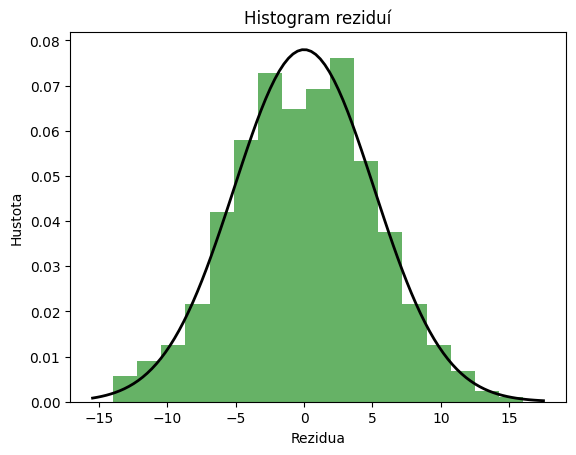

Vysledky jsou z normalniho rozdeleni 
Nepodarilo se mi nulovou hypotezu vyvratit, data maji homoskedasticitu
Nulovou hypotezu nezamitam, str. hodnota rezidui muze byt 0


In [12]:
# Splneni pozadavku regrese - zkontroluju, ze rezidua maji normalni rozdeleni za pomoci grafu a Shapiro testu

# Graf prevzaty z democvika
plt.hist(results_final.resid, bins='auto', density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(results_final.resid), np.std(results_final.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram reziduí")
plt.xlabel("Rezidua")
plt.ylabel("Hustota")
plt.show()

# Pro jistotu jeste Shapiro test normality rezidui, pokud to z grafu neni jasne
from scipy.stats import shapiro
if shapiro(results_final.resid)[1] > 0.01: # 99% spolehlivost
    print("Vysledky jsou z normalniho rozdeleni ")
else:
    print("Vysledky nejsou z normalniho rozdeleni")

# test na Heteroskedasticitu (Cook-Weisbergův / Breusch-Pagan), hladina vyznamnosti 0.05
# https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html
# Nulova hypoteza: data maji homoskedasticitu
# Alternativni: data maji Heteroskedasticitu
from statsmodels.stats.diagnostic import het_breuschpagan
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"] # me zajima hlavne p-hodnota
test = het_breuschpagan(results_final.resid, results_final.model.exog)
res = list(zip(name, test))
if (res[1][1] < 0.05):
    print("Odmitam nulovou hypotezu, v datech je heteroskedasticita")
else:
    print("Nepodarilo se mi nulovou hypotezu vyvratit, data maji homoskedasticitu")

# Test ze stredni hodntoa rezidui = 0, alt. hypoteza != 0, pouziju T-test s hladinou vyznamnosti 5%
print("Vyvracim nulovou hypotezu, stredni hodnota rezidui != 0" if stats.ttest_1samp(results_final.resid, 0).pvalue < 0.05 else "Nulovou hypotezu nezamitam, str. hodnota rezidui muze byt 0")

## 2.1.2) Diskuze předpokladů a diagnostika

Pro matici plánu zjevně platí, že $m < n$, protože $n$ je 499 (No. observations v modelu), zatímco m je v podstatě počet členů ve formuli, který je mnohem nižší (viz 2.1.1 Formule modelu).

Důležitým předpokladem regrese je ověření, že rezidua mají normální rozdělení. To je patrně splněno, jak vyplývá z grafu výše a také z provedeného Shapiro testu. 

Durbin-Watson test vychází 1.9, což naznačuje, že autokorelace mezi rezidui je poměrně nízká, což je další předpoklad.

Podle Cook-Weisbergova (Breusch-Pagan) testu jsem vyhodnotil, že data neobsahují heteroskedasticitu.

Nepodařilo se mi vyvrátit, že by střední hodnota reziduí byla jiná než 0, což je další splněný předpoklad.

Všechny podstatné regresní předpoklady jsou snad tedy splněny a diagnostika je v pořádku.

Regrese se dá označit za poměrně úspěšnou, protože koeficient determinace vysvětluje 0.873 % variability, což zní jako dostatečně vysoká hodnota.

## 2.2) Nejproblematičtější hodnota odezvy

Pro všechna pozorování spočítám odhad pingu. Nejvyšší ping je nejproblematičtější hodnota, takže zjistím jeho index a zobrazím nejproblematičtější hodnoty, které k němu vedly.

In [13]:
predicted_vals = results_final.predict(df3)
max_ind = np.argmax(predicted_vals) # argmax vraci index nejvyssi hodnoty namisto hodnoty samotne
most_problematic = df3.iloc[max_ind]

print("\n\n\n" + "Nejproblematictejsi hodnoty jsou na radku " + str(max_ind) + " a to:\n")
print(most_problematic)

print("\nPro ktere vychazi nejproblematictejsi ping: ", end='')

problematic_ping = results_final.predict(most_problematic)
print(problematic_ping.iloc[0])





Nejproblematictejsi hodnoty jsou na radku 10 a to:

ActiveUsers        1.636436
InteractingPct     1.636444
Ping              72.000000
MacOS              1.000000
Windows            0.000000
iOS                0.000000
Name: 10, dtype: float64

Pro ktere vychazi nejproblematictejsi ping: 77.29677000509997


## 2.3) Odezva uživatele s Windows při průměrném nastavení ostatních parametrů

Jako průměrné nastavení chápu průměr jednotlivých hodnot. To znamená ActiveUsers a InteractingPct. Hledá se uživatel s Windowsem, takže nastavím odpovídající One-Hot Encoding kde Windows bude 1 a ostatní OS budou 0.

In [14]:
mean_active = df3["ActiveUsers"].mean()
mean_int = df3["InteractingPct"].mean()

tmp_df_mean = pd.DataFrame({ # docasny dataframe do ktereho nakrmim sve prumerne hodnoty
    'ActiveUsers': [mean_active],
    'InteractingPct': [mean_int],
    'MacOS': [0],
    'Windows': [1],
    'iOS': [0]
})

predicted_windows = results_final.get_prediction(tmp_df_mean)
predicted_windows = predicted_windows.summary_frame(0.05) # 95% konfidence

confidence_interval_lower = predicted_windows.iloc[0]['mean_ci_lower']
confidence_interval_upper = predicted_windows.iloc[0]['mean_ci_upper']

prediction_interval_lower = predicted_windows.iloc[0]['obs_ci_lower']
prediction_interval_upper = predicted_windows.iloc[0]['obs_ci_upper']

print("Konfidencni interval se spolehlivosti 95%: <" + str(confidence_interval_lower) + ", " + str(confidence_interval_upper) + ">")
print("Predikcni interval se spolehlivosti 95%: <" + str(prediction_interval_lower) + ", " + str(prediction_interval_upper) + ">")

print("Predikovany ping: " + str(predicted_windows.iloc[0]['mean']))

Konfidencni interval se spolehlivosti 95%: <53.984762711510804, 56.034172659039065>
Predikcni interval se spolehlivosti 95%: <44.79332594156683, 65.22560942898303>
Predikovany ping: 55.009467685274934


### 2.4) Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model „vhodný“ pro další použití.


R-hodnota modelu je relativně slušná (0.873), což by se dalo použít jako argument, že model je pro nějaké základní použitý vhodný. Myslím si ale, že na vyvozování nějakých závěrů, podle kterých by se měla dělat zásadní rozhodnutí, to není úplně dost. Z modelu jsem odstraňoval nějaká data, která vypadala validně, ale chování modelu zhoršovala. Mít dat více, tyto hodnoty by se odstraňovat pravděpodobně nemuseli, protože už by nešlo o extrémy. Problém tedy je, že model je postavený na malém množství dat. Ideálně bych si sehnal další data, kterých by bylo mnohem více než 500. Kus těhle dat bych použil pro trénování regresního modelu a zbytek bych použil jako validační sadu, na které by se model ověřil.